In [1]:
import sys
sys.path.append(".")
sys.path.append("..")

In [2]:
from model.my_diffusers.models import AutoencoderKL_Pretrained
from utils.lora_utils.lora import inject_trainable_lora_extended
from warper.so2_warper import SO2_warper
from diffusers import AutoencoderKL

In [3]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as nnf
import numpy as np
import shutil
from torch.optim.adam import Adam
from PIL import Image
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchgeometry as tgm
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
import numpy.typing as npt
from jaxtyping import Float
from torch import Tensor
from pathlib import Path
import json
import random
import os
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from math import log10, sqrt
import copy
import tyro
from dataclasses import dataclass

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [5]:
def latent2image(latents, return_type='torch', vae=None):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    if return_type == 'np':
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = (image * 255).astype(np.uint8)

    if return_type == 'torch':
        image = (image / 2 + 0.5).clamp(0, 1)

    return image

def torch_to_pil(img):
    if img.dim() == 4:
        img = img.squeeze(0)
        
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255.0).astype(np.uint8)
    img = Image.fromarray(img)
    
    return img

def mse(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    return mse

def mse_psnr(original, predicted):
    mse_val = mse(original, predicted)
    if(mse_val == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse_val))
    return mse_val, psnr

def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

def sub_vec(A, B):
    return np.linalg.norm(A - B) / np.linalg.norm(A)

In [6]:
ckpt_path = "/home/jh27kim/warp_latent/ckpt/dec_lora_ep_9.pt"
state_dict = torch.load(ckpt_path)
device = 0

In [7]:
class VAE_lora_dec(SO2_warper):
    def __init__(self) -> None:
        self.device = device
        self.autoencoder_pretrained = AutoencoderKL_Pretrained.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(self.device)

        self.target_replace_module = {"UNetMidBlock2D", "UpDecoderBlock2D"}
        self.lora_params, train_names = inject_trainable_lora_extended(self.autoencoder_pretrained.decoder, target_replace_module=self.target_replace_module, verbose=False)
        
        self.raw_vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
        self.raw_vae.to(self.device)


    def latent2image(self, src_latent):
        # NOTE: Image should be normalized -1 1
        src_latent = 1 / self.autoencoder_pretrained.config.scaling_factor * src_latent

        imgs = self.autoencoder_pretrained.decode(src_latent).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs
    
    def image2latent(self, img):
        # imgs: [B, 3, H, W]
        img = 2 * img - 1

        posterior = self.autoencoder_pretrained.encode(img).latent_dist
        latents = posterior.sample() * self.autoencoder_pretrained.config.scaling_factor

        return latents
    
    def raw_latent2image(self, latent):
        latent = 1 / self.raw_vae.config.scaling_factor * latent
        img = self.raw_vae.decode(latent).sample
        img = (img / 2 + 0.5).clamp(0, 1)
        return img
    
lora_dec = VAE_lora_dec()
lora_dec.autoencoder_pretrained.decoder.load_state_dict(state_dict["decoder_lora"])
print("Loaded LoRA decoder")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loaded LoRA decoder


In [8]:
# AFHQ dataset

# image_path = "/home/jh27kim/warp_latent/dataset/afhq/val/wild/image"
# image_path = [os.path.join(image_path, i) for i in os.listdir(image_path)]
# print(image_path[0], len(image_path))

In [19]:
# # CelebA dataset - Needs to be cropped
# import pathlib

# target_index = np.random.randint(0, 200000, 500)

# image_filepath = "/home/jh27kim/warp_latent/dataset/objaverse/img_align_celeba/img_align_celeba"
# image_path = []
# # pl = pathlib.Path(image_path).iterdir()
# for tar_idx in target_index:
#     target_filename = str(tar_idx).zfill(6) + ".jpg"
#     if os.path.exists(os.path.join(image_filepath, target_filename)):
#         image_path.append(os.path.join(image_filepath, target_filename))
        
# print(image_path[0], len(image_path))

/home/jh27kim/warp_latent/dataset/CelebA/img_align_celeba/img_align_celeba/182174.jpg 500


In [91]:
# Objaverse dataset

image_path = "/home/jh27kim/warp_latent/dataset/objaverse"
image_path = [os.path.join(image_path, i) for i in os.listdir(image_path)]
print(image_path[0], len(image_path))

/home/jh27kim/warp_latent/dataset/objaverse/80.png 10


In [101]:
# Comparison in image space

scale = torch.ones(1)

PSNR_finetune = []
PSNR_raw = []

SSIM_finetune = []
SSIM_raw = []

MSE_finetune = []
MSE_raw = []

with torch.no_grad():
    for i, img_path in enumerate(image_path):
        src_img = Image.open(img_path).convert('RGB')
        init_width, init_height = src_img.size
        if init_width != 512 or init_height != 512:
            src_img = src_img.resize((512, 512))
        src_img = (np.array(src_img) / 255.0).astype(np.float32)
        src_img = torch.tensor(src_img).permute(2, 0, 1).unsqueeze(0).to(device)
        
        src_latent = lora_dec.image2latent(src_img)
        angle = (torch.rand(1) - 0.5) * 2 # -1 ~ 1
        angle *= 180.0
        
        latent_center = torch.ones(1, 2)
        latent_center[..., 0] = src_latent.shape[3] / 2  # x
        latent_center[..., 1] = src_latent.shape[2] / 2  # y
        
        # Latent warp
        _, _, latent_h, latent_w = src_latent.shape
        latent_SO2 = lora_dec.get_rotation_matrix2d(latent_center.to(src_img), angle.to(src_img), scale.to(src_img))
        SO2_warp_latent = lora_dec.warp_affine(src_latent, 
                                latent_SO2, 
                                dsize=(latent_h, latent_w), 
                                interpolation_mode="bilinear", 
                                padding_mode="reflection")
        
        res_finetune = lora_dec.latent2image(SO2_warp_latent)
        res_raw = lora_dec.raw_latent2image(SO2_warp_latent)
        
        # Image warp
        img_center = torch.ones(1, 2)
        img_center[..., 0] = src_img.shape[3] / 2  # x
        img_center[..., 1] = src_img.shape[2] / 2  # y
        img_SO2 = lora_dec.get_rotation_matrix2d(img_center.to(src_img), angle.to(src_img), scale.to(src_img)) 
        _, _, img_h, img_w = src_img.shape

        tar_img = lora_dec.warp_affine(src_img, 
                              img_SO2, 
                              dsize=(img_h, img_w), 
                              interpolation_mode="bilinear", 
                              padding_mode="reflection")
        
        res_finetune_numpy = np.array(torch_to_pil(res_finetune))
        res_raw_numpy = np.array(torch_to_pil(res_raw))
        res_target_numpy = np.array(torch_to_pil(tar_img))
        
        mse_raw, psnr_raw = mse_psnr(res_target_numpy, res_raw_numpy)
        mse_finetune, psnr_finetune = mse_psnr(res_target_numpy, res_finetune_numpy)
        
        SSIM_finetune.append(ssim(res_target_numpy, res_finetune_numpy, channel_axis=-1))
        SSIM_raw.append(ssim(res_target_numpy, res_raw_numpy, channel_axis=-1))
        
        PSNR_finetune.append(psnr_finetune)
        PSNR_raw.append(psnr_raw)
    
        MSE_finetune.append(mse_finetune)
        MSE_raw.append(mse_raw)
        
        print(f"{i+1} / {len(image_path)}")


1 / 10


In [96]:
compute_mean = lambda x: np.mean(np.array(x))
for arr in [MSE_raw, MSE_finetune, PSNR_raw, PSNR_finetune, SSIM_raw, SSIM_finetune]:
    print(compute_mean(arr))

17.560036722819014
22.06124928792318
35.932671092912344
34.955891615206546
0.9011305805496626
0.9037655474125803


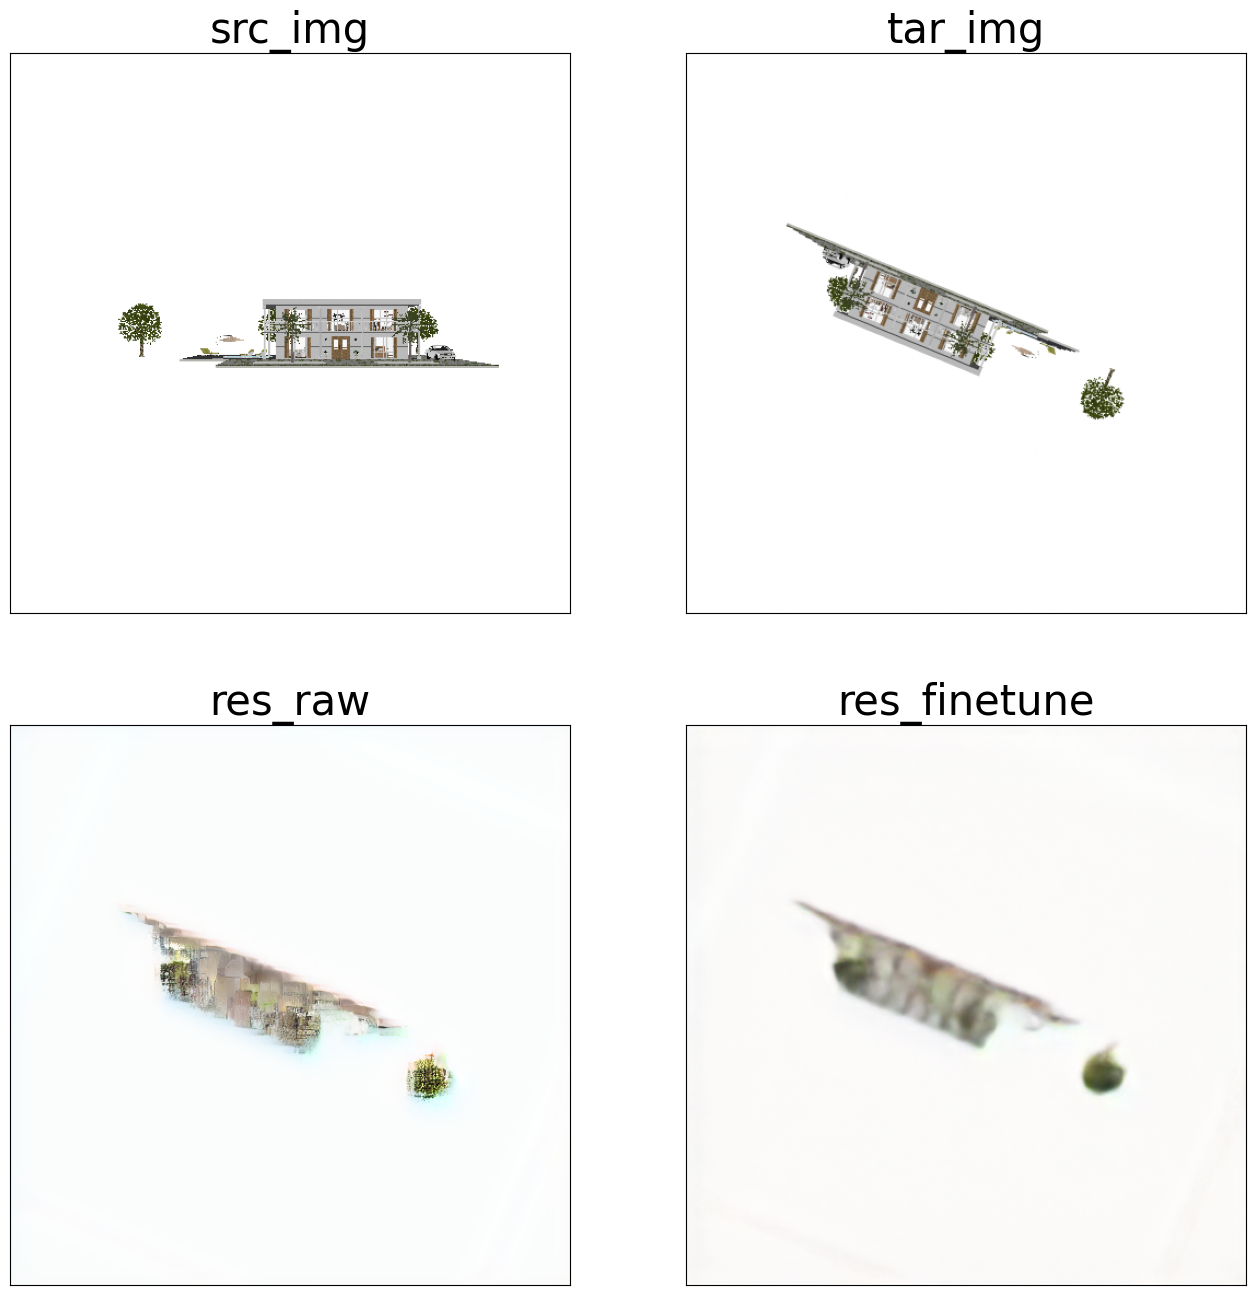

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
plot_img = [src_img, tar_img, res_raw, res_finetune]
plot_title = ["src_img", "tar_img", "res_raw", "res_finetune"]

for i, ax in enumerate(axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_title[i], fontsize=30)
    ax.imshow(torch_to_pil(plot_img[i]))

In [9]:
# Objaverse 
import random
import objaverse

random.seed(42)

uids = objaverse.load_uids()
random_object_uids = random.sample(uids, 100)

random_object_uids

['f82039689f504922995936c68484aa61',
 'fb42332b3f5e491cb0c4b5ba7ed6f374',
 'd633b522306b4499a8e6f1ac5f517864',
 '89da97b84f4d4fbc825bf3e914d45e92',
 '32aaba5aa1954cb898111bf884404039',
 'f84c8cbd56d94be18a727c66de2c2d51',
 '6afcf8814d494372a4f3f7e3b99219ba',
 '38cb6584bb734d729baf712da41b141f',
 'f9b8b1cea04243a7bf706c4565027187',
 '306aa51bb3c24464886dce788547e6cb',
 'df4d2da4e9934b82b30f9bcab685a0fd',
 '45509feed4534fa1a34567ae82c457cf',
 'b86569c202fa455b8d221e90c5588cc7',
 '00ae6eda19634ee6b0a4a52789c9ff90',
 'bfd6abe69bde4ee7806ef3fa483b0655',
 '1b1c987aa5914a4f85eecca0a6ba9b4e',
 '7842c2ad6fe74224974d64958baea75d',
 'a018d452856f4452958e081f77cdc253',
 '9e6bd36b7b94412a9c71fdc34561a934',
 '6845849028774ca782f0e2e221c69944',
 '60a206c7952c420e844640de850f4fcf',
 'd0ca35386b0b48418f8669da1bea0923',
 '61955029fd2c48d9a6eb6c6097f93b6c',
 '329684e1e63d4d16bcf519cc9571c1fb',
 '06d70683684b4b4cbc3da27c5507ee6a',
 '71aad2b07e5a4d4bb75f4acbdb6a1aa2',
 '4954590a8ea7404f9c4a83a446313f07',
 

In [10]:
import multiprocessing
processes = multiprocessing.cpu_count()
processes

48

In [33]:
objects = objaverse.load_objects(
    uids=random_object_uids,
    download_processes=processes
)
objects

{'f82039689f504922995936c68484aa61': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-120/f82039689f504922995936c68484aa61.glb',
 'fb42332b3f5e491cb0c4b5ba7ed6f374': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-003/fb42332b3f5e491cb0c4b5ba7ed6f374.glb',
 'd633b522306b4499a8e6f1ac5f517864': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-011/d633b522306b4499a8e6f1ac5f517864.glb',
 '89da97b84f4d4fbc825bf3e914d45e92': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-143/89da97b84f4d4fbc825bf3e914d45e92.glb',
 '32aaba5aa1954cb898111bf884404039': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-136/32aaba5aa1954cb898111bf884404039.glb',
 'f84c8cbd56d94be18a727c66de2c2d51': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-110/f84c8cbd56d94be18a727c66de2c2d51.glb',
 '6afcf8814d494372a4f3f7e3b99219ba': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs/000-068/6afcf8814d494372a4f3f7e3b99219ba.glb',
 '38cb6584bb734d729baf712da41b141f': '/home/jh27kim/.objaverse/hf-objaverse-v1/glbs

In [90]:
import trimesh
import pyrender
import io

for i in range(500):
    obj = trimesh.load(list(objects.values())[i])
    obj_center = obj.centroid
    obj_distance = np.linalg.norm(np.array(obj_center))
    _left_end, _right_end = obj.bounds
    obj_scale = np.linalg.norm(_left_end - _right_end) / 8.0
    print(i)

    obj.set_camera(angles=(0.0, 0.0, 0.0),
                   distance=obj_distance * obj_scale,
                   center=obj_center,
                   resolution=(512.0, 512.0),
                   fov=(60, 60))

    obj_img = obj.save_image(resolution=(512, 512))
    pil_img = Image.open(io.BytesIO(obj_img))
    pil_img.save(f"/home/jh27kim/warp_latent/dataset/objaverse/{i}.png")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IndexError: list index out of range